# Estimating Urban Service Levels

First we load city boundaries, and partition the city in a grid

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('..')
import urbanpy as up
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

## How are we going to estimate urban service level?

For each hexagon (centroid) we are going to generate isochrones for 30 minutes walk, with 5 minutes bands. For each band we are going to count the number of PoIs by categories.

### Isochrones Demo

#### Load Graphs

In [25]:
pos_id = 0
lima_boundaries = up.download.nominatim_osm('Lima, Peru', pos_id)

<Axes: >

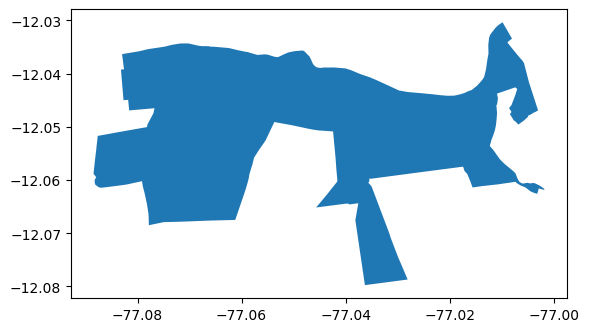

In [26]:
lima_boundaries.plot()

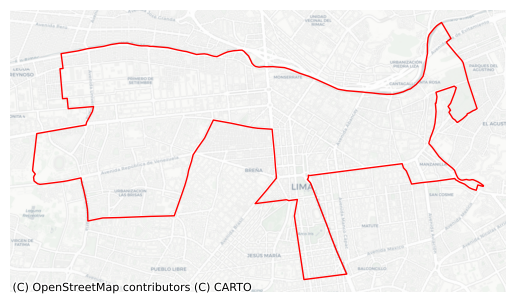

In [27]:
ax = lima_boundaries.plot(facecolor='none', edgecolor='r')
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

In [15]:
lima_downtown_graph = up.download.osmnx_graph('polygon', 'walk', geom=lima_boundaries.envelope[pos_id])

#### Generate isochrone from the centroid of the district

In [33]:
isochrones = up.routing.isochrone_from_graph(
    graph=lima_downtown_graph, 
    locations=[[lima_boundaries.centroid[pos_id].x, lima_boundaries.centroid[pos_id].y]],
    time_range=[5, 10, 15, 20, 25],
    profile='walking'
)

#### Visualize isochrone

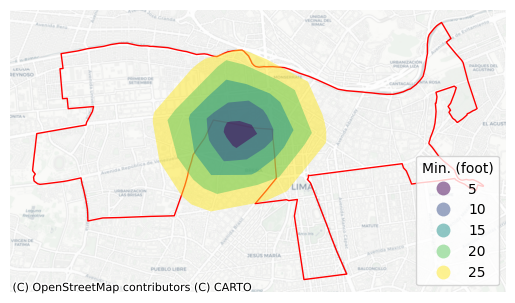

In [46]:
ax = lima_boundaries.to_crs(isochrones.crs).plot(facecolor='none', edgecolor='r')
isochrones.plot('contour', alpha=0.5, cmap='viridis',  ax=ax, legend=True, categorical=True, 
                legend_kwds={"title": "Min. (foot)", "loc":"lower right"})
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

### Scale isochrone calculation up to every hexagon centroid in Lima's Downtown

In [48]:
lima_hexs = up.geom.gen_hexagons(resolution=9, city=lima_boundaries)

In [49]:
lima_hexs.shape

(172, 2)

In [52]:
lima_hexs['lon'] = lima_hexs.geometry.centroid.x
lima_hexs['lat'] = lima_hexs.geometry.centroid.y
hexs_centroids = lima_hexs[['lon','lat']].values

In [57]:
import os
OUTPUT_FILE_PATH = 'output/lima_downtown_isochrones.geojson'

In [58]:
if os.path.isfile(OUTPUT_FILE_PATH):
    downtown_isochrones = gpd.read_file(OUTPUT_FILE_PATH)
else:
    downtown_isochrones = up.routing.isochrone_from_graph(
        graph=lima_graph, 
        locations=hexs_centroids,
        time_range=[5, 10, 15, 20, 25, 30], 
        profile='walking'
    )
    # Validate every geom is of the correct type
    if (downtown_isochrones.geom_type != 'Polygon').sum() == 0:
        # Save output
        downtown_isochrones.to_file(OUTPUT_FILE_PATH, driver='GeoJSON')

In [59]:
downtown_isochrones.head()

,group_index,contour,geometry
0,0,25,"POLYGON ((-77.03762 -12.05846, -77.04161 -12.0..."
1,0,20,"POLYGON ((-77.03823 -12.05511, -77.04194 -12.0..."
2,0,15,"POLYGON ((-77.03879 -12.05152, -77.04093 -12.0..."
3,0,10,"POLYGON ((-77.04003 -12.04822, -77.04091 -12.0..."
4,0,5,"POLYGON ((-77.03777 -12.04493, -77.03835 -12.0..."


In [15]:
downtown_isochrones.shape

(860, 3)

#### Visualize an isochromes sample in a map

In [62]:
SAMPLE_SIZE = 5

In [63]:
# Create sample & filter time ranges for a better visualization
n_isochrones = downtown_isochrones.shape[0]
random_indices = np.random.choice(downtown_isochrones['group_index'].unique(), size=SAMPLE_SIZE, replace=False)

sample_filter = downtown_isochrones['group_index'].isin(random_indices)
timer_filter = downtown_isochrones['contour'].isin([5, 10, 15])

ischrones_rsample = downtown_isochrones[sample_filter & timer_filter]

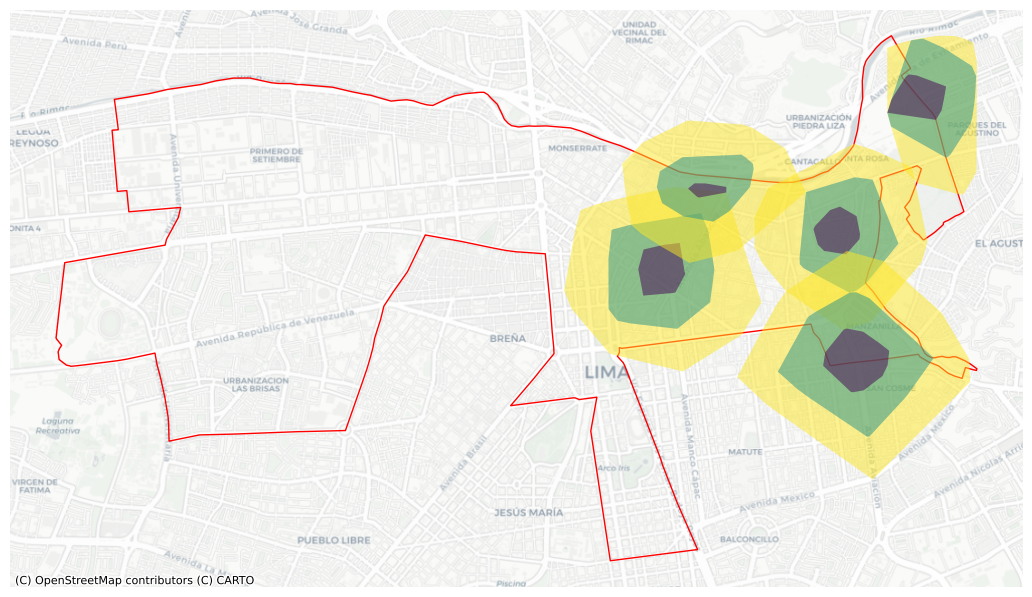

In [64]:
ax = lima_boundaries.to_crs(isochrones.crs).plot(facecolor='none', edgecolor='r', figsize=(15,7.5))
ischrones_rsample.plot('contour', alpha=0.5, ax=ax)
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

### Which PoIs categories we can use to calculate service levels?

- Food & Beverage (Restaurants & similar )
- Cultural places
- Night Places
- Pharmacies & Sanitization
- Sports Equiptment 
- Clothes & Shoes
- Furniture
- Beauty
- Nanostores
- Traditional Markets

To be continued ...

In [28]:
buildings = dict(acommodation = ["apartments"
, "bungalow"
, "cabin"
, "detached"
, "dormitory"
, "farm"
, "ger"
, "hotel"
, "house"
, "houseboat"
, "residential"
, "semidetached_house"
, "static_caravan"
, "terrace"],

commercial = ["commercial"
,"industrial" 
,"kiosk" 
,"office" 
,"retail" 
,"supermarket" 
,"warehouse" ],

religious = ["cathedral" 
,"chapel" 
,"church" 
,"mosque" 
,"religious" 
,"shrine" 
,"synagogue" 
,"temple" ],

civic = ["bakehouse" 
,"civic" 
,"fire_station" 
,"government" 
,"hospital" 
,"kindergarten" 
,"public" 
,"school" 
,"toilets" 
,"train_station" 
,"transportation" 
,"university" ],

agricultural = ["barn" 
,"conservatory" 
,"cowshed" 
,"farm_auxiliary" 
,"greenhouse" 
,"slurry_tank" 
,"stable" 
,"sty" ],

sports = ["grandstand" 
,"pavilion" 
,"riding_hall" 
,"sports_hall" 
,"stadium" ],

storage = ["hangar" 
,"hut" 
,"shed" ],

cars = ["carport" 
,"garage" 
,"garages" 
,"parking" ],

technical = ["digester" 
,"service" 
,"transformer_tower" 
,"water_tower" ],

others = ["bunker" 
,"bridge" 
,"construction" 
,"gatehouse" 
,"roof" 
,"ruins" 
,"tree_house" 
,"yes" 
,"user defined"],)

In [29]:
shops = dict(foood_and_beverages = ["alcohol","bakery","beverages",
                       "brewing_supplies","butcher","cheese",
                       "chocolate","coffee","confectionery",
                       "convenience","deli","dairy","farm",
                       "frozen_food","greengrocer","health_food",
                       "ice_cream","organic","pasta","pastry",
                       "seafood","spices","tea","wine","water"],

mall = ["department_store", "general", "kiosk", "mall",
        "supermarket", "wholesale"],

clothing = ["baby_goods", "bag", "boutique", "clothes", "fabric", 
            "fashion", "fashion_accessories", "jewelry", "leather", 
            "sewing", "shoes", "tailor", "watches", "wool",],

discount_store = ["charity", "second_hand", "variety_store"],

health_and_beauty = ["beauty", "chemist", "cosmetics", "drugstore",
                     "erotic", "hairdresser", "hairdresser_supply", 
                     "hearing_aids", "herbalist", "massage", 
                     "medical_supply", "nutrition_supplements", 
                     "optician", "perfumery", "tattoo"],

diy = ["agrarian", "appliance", "bathroom_furnishing", "doityourself",
       "electrical", "energy", "fireplace", "florist", "garden_centre",
       "garden_furniture", "gas", "glaziery", "hardware", "houseware",
       "locksmith", "paint", "security", "trade", "windows"],

furniture_and_interior = ["antiques", "bed", "candles", "carpet",
                          "curtain", "doors", "flooring", "furniture",
                          "household_linen", "interior_decoration", 
                          "kitchen", "lamps", "lighting", "tiles",
                          "window_blind"],

electronics = ["computer", "electronics", "hifi", "mobile_phone",
               "radiotechnics", "vacuum_cleaner"],

outdoors = ["atv", "bicycle", "boat", "car", "car_repair", "car_parts",
            "caravan", "fuel", "fishing", "golf", "hunting", "jetski",
            "military_surplus", "motorcycle", "outdoor", "scuba_diving",
            "ski", "snowmobile", "sports", "swimming_pool", "trailer", 
            "tyres"],

art = ["art", "collector", "craft", "frame", "games", "model",
       "music", "musical_instrument", "photo", "camera", "trophy",
       "video", "video_games"],

books = ["anime", "books", "gift", "lottery", "newsagent",
         "stationery", "ticket"],

others = ["bookmaker", "cannabis", "copyshop", "dry_cleaning",
          "e-cigarette", "funeral_directors", "laundry", 
          "money_lender", "party", "pawnbroker", "pet", 
          "pet_grooming", "pest_control", "pyrotechnics",
          "religion", "storage_rental", "tobacco", "toys", 
          "travel_agency", "vacant", "weapons", "outpost"],)

In [30]:
## Amenity*

### Sustenance
amenities = dict(sustenance = ["bar", "bbq", "biergarten", "cafe", "drinking_water", "fast_food", 
          "food_court", "ice_cream", "pub", "restaurant"],

### Education
education = ["college", "kindergarten", "language_school", "library", "toy_library",
          "music_school", "school", "university"],

### Transportation
transportation = ["bicycle_parking", "bicycle_repair_station", "bicycle_rental",
          "boat_rental", "boat_sharing", "bus_station", "car_rental",
          "car_sharing", "car_wash", "vehicle_inspection", "charging_station",
          "ferry_terminal", "fuel", "grit_bin", "motorcycle_parking", "parking",
          "parking_entrance", "parking_space", "taxi"],

### Financial
financial = ["atm", "bank", "bureau_de_change"],

### Healthcare
healthcare = ["baby_hatch", "clinic", "dentist", "doctors", "hospital",
           "nursing_home", "pharmacy", "social_facility", "veterinary"],

### Entertainment", "Arts & Culture
entertainment = ["arts_centre", "brothel", "casino", "cinema", "community_centre",
          "fountain", "gambling", "nightclub", "planetarium", "public_bookcase",
          "social_centre", "stripclub", "studio", "swingerclub", "theatre"],

### Others
others = ["animal_boarding", "animal_shelter", "baking_oven", "bench",
          "childcare", "clock", "conference_centre", "courthouse", "crematorium",
          "dive_centre", "embassy", "fire_station", "firepit", "funeral_hall",
          "give_box", "grave_yard", "gym", "hunting_stand", "internet_cafe",
          "kitchen", "kneipp_water_cure", "monastery", "photo_booth",
          "place_of_worship", "polic", "post_box", "post_depot", "post_office",
          "prison", "public_bath", "public_building", "ranger_station",
          "recycling", "refugee_site", "sanitary_dump_station", "sauna",
          "shelter", "shower", "telephone", "toilets", "townhall",
          "vending_machine", "waste_basket", "waste_disposal",
          "waste_transfer_station", "watering_place", "water_point"])

In [31]:
def gen_mapper(values):
    mapper = dict()

    for key, value in values.items():
        for el in value:
            mapper[el] = key
            
    return mapper

In [43]:
shop_mapper = gen_mapper(shops)
amenities_mapper = gen_mapper(amenities)

In [33]:
query = """
[timeout:120][out:json][bbox];
(
  node[shop];
);
out body geom;
"""
response = up.download.overpass_pois(lima_boundaries.total_bounds, custom_query=query)

In [36]:
data = response.json() # get json data
overpass_df = pd.DataFrame.from_dict(data['elements']) # transform data to dataframe

In [37]:
overpass_df_with_tags = overpass_df[~overpass_df['tags'].isna()]

In [38]:
overpass_df.shape, overpass_df_with_tags.shape

((1373, 5), (1373, 5))

In [39]:
tags_records = overpass_df_with_tags['tags'].values.tolist()

In [40]:
tags_df = pd.DataFrame.from_records(tags_records)

In [41]:
tags_df['shop'].value_counts()

yes                   230
convenience           116
clothes               103
mall                   55
hardware               54
                     ... 
dairy                   1
photo_studio            1
no                      1
building_materials      1
trophy                  1
Name: shop, Length: 96, dtype: int64

In [44]:
categories = tags_df['amenity'].map(amenities_mapper)

<AxesSubplot:>

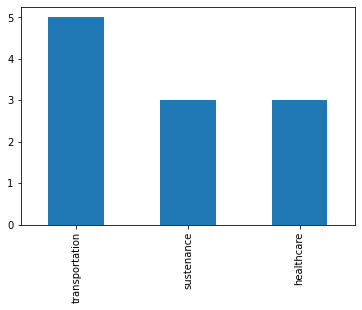

In [45]:
categories.value_counts().plot(kind='bar')

In [46]:
services = tags_df['shop'].map(shop_mapper)

In [47]:
services.isna().sum(), services.shape

(242, (1373,))

<AxesSubplot:>

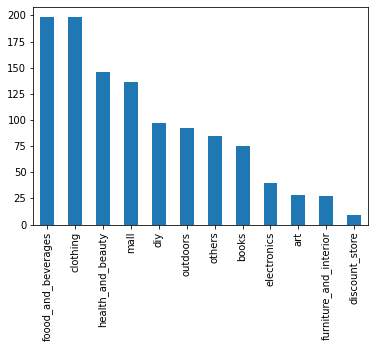

In [48]:
services.value_counts().plot(kind='bar')

In [49]:
tags_df['shop_category'] = services

In [50]:
overpass_geo = gpd.points_from_xy(overpass_df_with_tags.lon, overpass_df_with_tags.lat)

In [51]:
overpass_gdf = gpd.GeoDataFrame(
    pd.concat([overpass_df_with_tags, tags_df], axis=1),
    geometry=overpass_geo,
    crs='EPSG:4326'
)

<AxesSubplot:>

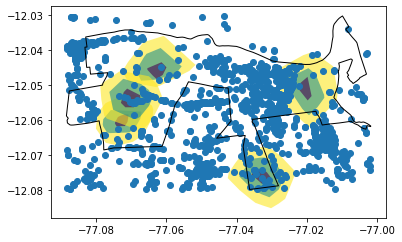

In [55]:
ax = overpass_gdf.plot()
lima_boundaries.plot(ax=ax, facecolor='none', edgecolor='k')
ischrones_rsample.plot('contour', ax=ax, alpha=0.6, zorder=-1)

In [ ]:
from collections import defaultdict 

In [81]:
def count_pois(row):
    intersects = overpass_gdf.intersects(row.geometry)
    
    if intersects.sum() > 0:
        pois_count = (overpass_gdf[intersects]
        .groupby('shop_category').count()['geometry'])
        
        return pois_count
    
    return np.nan

pois_count = downtown_isochrones.apply(count_pois, axis=1)

In [82]:
pois_count

,art,books,clothing,discount_store,diy,electronics,foood_and_beverages,furniture_and_interior,health_and_beauty,mall,others,outdoors
0,13.0,9.0,8.0,NaN,28.0,7.0,23.0,1.0,38.0,6.0,10.0,27.0
1,10.0,4.0,8.0,NaN,19.0,6.0,7.0,NaN,15.0,5.0,6.0,21.0
2,1.0,NaN,6.0,NaN,13.0,5.0,2.0,NaN,5.0,2.0,1.0,4.0
3,NaN,NaN,2.0,NaN,3.0,NaN,1.0,NaN,NaN,1.0,NaN,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,2.0,9.0,4.0,2.0,8.0,3.0,27.0,5.0,13.0,12.0,15.0,9.0
1028,2.0,7.0,2.0,1.0,5.0,NaN,16.0,4.0,10.0,6.0,9.0,2.0
1029,1.0,6.0,2.0,NaN,3.0,NaN,16.0,4.0,9.0,2.0,7.0,2.0
1030,1.0,5.0,NaN,NaN,1.0,NaN,9.0,NaN,3.0,1.0,1.0,1.0


In [80]:
downtown_isochrones.shape

(1032, 3)

In [87]:
downtown_iso = pd.concat([downtown_isochrones, pois_count], axis=1)

In [88]:
downtown_iso.to_file('output/lima_downtown_isochrones_poi_count.geojson', driver='GeoJSON')

In [90]:
downtown_iso['contour'].unique()

array([30, 25, 20, 15, 10,  5])